### (2) Market Basket Analysis

Problem Statement: Our merchandising team wishes to introduce bundles for all products on our website to increase the average basket size when customers make an online purchase. Describe clearly how you will work on this problem, and the insights you can draw from this analysis.

Deliverables:
Provide a clear explanation of your methodology. This includes:

(1) Listing down the features you used (if any).

(2) Explanation of how your proposed approach could be used to solve this business problem.

(3) Highlighting the limitations and caveats of your approach.

(4) What are the business insights that you recommend based on your findings?

# Table of Content

1.[Data Preprocessing](#dp)

2.[FP-Growth Algorithm](#fp)

3.[Business Insight](#bi)

4.[Limitation](#l)

### 1.Data Preprocessing <a id="dp"></a>

1. The problem focus on the website, so we first filter the transactions on the website.


2. Since the distribution of sku_idr_sku is highly positive skewed, which means most sku_idr_sku only appear few times in the dataset, we will exclude those infrequent sku_idr_sku for better pattern mining.


3. In original dataset, each row only contains one sku_idr_sku so we need to first group by the_transaction_id to find out products in the same basket.


4. In a basket, same sku_idr_sku may appear multiple times, so we use set to remove duplication.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Recruitment_Transactions_ToBeDistributed.csv')

In [3]:
#remove Unnamed: 0 column
df = df.iloc[:,1:]

In [4]:
#column preprocessing(change columns into proper data type)
#Convert the_date_transaction column to datetime
df['the_date_transaction'] = pd.to_datetime(df['the_date_transaction'])
#only include rows with f_qty_item and f_to_tax_in not equal to 0
df=df[(df['f_qty_item'] != 0) & (df['f_to_tax_in'] != 0)]
#only include online transaction
df = df[df['the_to_type']=='online']

In [5]:
df.shape

(533688, 10)

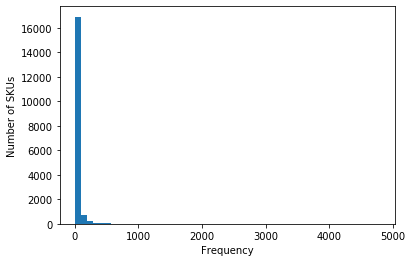

In [6]:
#the distribution is highly skewed, most sku_idr_sku only appear few times
sku_counts = df['sku_idr_sku'].value_counts()
plt.hist(sku_counts.values, bins=50)
plt.xlabel('Frequency')
plt.ylabel('Number of SKUs')
plt.show()

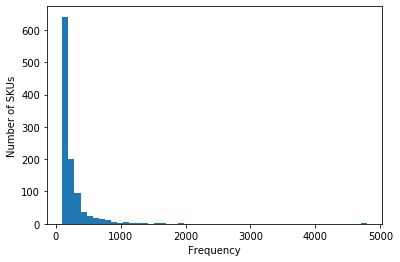

In [7]:
#if we only include sku_counts >= 100, the distribution pattern can be clearer
#100 here is a hyperparameter, which can be changed based on domain knowledge
plt.hist(sku_counts[sku_counts >= 100].values, bins=50)
plt.xlabel('Frequency')
plt.ylabel('Number of SKUs')
plt.show()

In [8]:
#To perform pattern mining, the current dataset is too big, which may encounter memory issue 
#Also, it doesn't make sense to include infrequent products into analysis
#So we first exclude those rows with sku_idr_sku that appears less than 100
sku_counts = df['sku_idr_sku'].value_counts()
valid_skus = sku_counts[sku_counts >= 100].index
filtered_df = df[df['sku_idr_sku'].isin(valid_skus)]

In [9]:
#there are 1068 valid products
valid_skus.shape

(1068,)

In [10]:
#after filtering, the new dataset has a 256782 rows
filtered_df.shape

(256782, 10)

In [11]:
#To know what products are in the same basket, we need to first transform df 
new_df = filtered_df.groupby('the_transaction_id')['sku_idr_sku'].agg(list).reset_index()

In [12]:
#there may be some duplicate in the list, for example, the first row has multiple 7200852 in the list
new_df

,the_transaction_id,sku_idr_sku
0,7-1034-1034-20200701114220-102-6102,"[7200852, 7200852, 7200852, 7200852, 7200852, ..."
1,7-1034-1034-20200701114619-102-6103,"[7200852, 7200852, 7200852, 7200852, 7200852, ..."
2,7-1034-1034-20200701115438-102-6106,"[7364235, 7238085, 7116403]"
3,7-1034-1034-20200701115845-102-6107,[2024828]
4,7-1034-1034-20200701120319-102-6108,[7351035]
...,...,...
130054,7-969-969-20201231213532-215-9561,[1769129]
130055,7-969-969-20201231213922-216-174,[5143720]
130056,7-969-969-20201231214031-215-9562,[7008837]
130057,7-969-969-20201231214031-215-9563,[1769129]


In [13]:
# To exclue the duplication, we can use set to make 'sku_idr_sku' unique
new_df['sku_idr_sku'] = new_df['sku_idr_sku'].apply(lambda x: list(set(x)))

In [14]:
new_df

,the_transaction_id,sku_idr_sku
0,7-1034-1034-20200701114220-102-6102,[7200852]
1,7-1034-1034-20200701114619-102-6103,[7200852]
2,7-1034-1034-20200701115438-102-6106,"[7364235, 7238085, 7116403]"
3,7-1034-1034-20200701115845-102-6107,[2024828]
4,7-1034-1034-20200701120319-102-6108,[7351035]
...,...,...
130054,7-969-969-20201231213532-215-9561,[1769129]
130055,7-969-969-20201231213922-216-174,[5143720]
130056,7-969-969-20201231214031-215-9562,[7008837]
130057,7-969-969-20201231214031-215-9563,[1769129]


### 2.FP-Growth Algorithm <a id="fp"></a>

1. To increase the basket size, one way is to find the association rules and recommend products that customers may like to them.


2. There are several algorithms available for association rule mining. The most famous one is Apriori Algorithm, which generates candidate itemsets of increasing size, and prun those that do not meet the minimum support threshold. However for big dataset, it may be less efficient.


3. To solve above problem, I used FP-Growth Algorithm. This alogorithm works by building a tree structure to represent the transactions, and using this tree to efficiently find frequent itemsets.


4. Some hyperparameters are set and they can be adjusted based on domain knowledge. For example, in below code, minimum support count is set to be 0.05% of total transactions; minimum confidence threshold is set to be 0.5, which means when Antecedent appears, ther is 50% chance that Consequent also appears.

In [15]:
import pyfpgrowth 

# mine frequent itemsets
frequent_itemsets = pyfpgrowth.find_frequent_patterns(
    transactions=new_df['sku_idr_sku'],
    support_threshold=new_df.shape[0]*0.0005  # minimum support count = 0.05% of total transactions
)
for itemset, support in frequent_itemsets.items():
    print('Itemset: {} \t Support: {}'.format(itemset, support))

Itemset: (1819587,) 	 Support: 75
Itemset: (1904222,) 	 Support: 77
Itemset: (7226527,) 	 Support: 78
Itemset: (1679832,) 	 Support: 80
Itemset: (18983,) 	 Support: 81
Itemset: (2434407,) 	 Support: 81
Itemset: (7004659,) 	 Support: 81
Itemset: (395214,) 	 Support: 82
Itemset: (622484,) 	 Support: 84
Itemset: (6999523,) 	 Support: 86
Itemset: (7114924,) 	 Support: 87
Itemset: (905216,) 	 Support: 87
Itemset: (7217474,) 	 Support: 89
Itemset: (1000706,) 	 Support: 90
Itemset: (7361976,) 	 Support: 92
Itemset: (1375184,) 	 Support: 92
Itemset: (6999866,) 	 Support: 92
Itemset: (7363713,) 	 Support: 93
Itemset: (1455489,) 	 Support: 94
Itemset: (1164876,) 	 Support: 96
Itemset: (6968678,) 	 Support: 97
Itemset: (7179441,) 	 Support: 97
Itemset: (7002721,) 	 Support: 98
Itemset: (7275246,) 	 Support: 98
Itemset: (7369847,) 	 Support: 98
Itemset: (2423946,) 	 Support: 98
Itemset: (6988590,) 	 Support: 98
Itemset: (870286,) 	 Support: 99
Itemset: (7271636,) 	 Support: 99
Itemset: (6981810,) 

In [16]:
# generate association rules
min_confidence = 0.5  # minimum confidence threshold, when Antecedent appears, ther is 50% chance that Consequent also appears
rules = pyfpgrowth.generate_association_rules(
    frequent_itemsets,
    min_confidence
)
#sort rules by its confidence 
sorted_rules = dict(sorted(rules.items(), key=lambda x: x[1][1], reverse=True))

In [17]:
# print the association rules
for antecedent, consequent in sorted_rules.items():
    consequence, confidence = consequent
    print('Antecedent: {} => Consequent: {} \t Confidence: {}'.format(
        antecedent, consequence, confidence))

Antecedent: (7214595, 7221993) => Consequent: (7216672,) 	 Confidence: 0.8933333333333333
Antecedent: (7200852, 7213375, 7217369) => Consequent: (7204288,) 	 Confidence: 0.8717948717948718
Antecedent: (1001612,) => Consequent: (2461867,) 	 Confidence: 0.8272727272727273
Antecedent: (6978775, 6978798) => Consequent: (6979014,) 	 Confidence: 0.7241379310344828
Antecedent: (7200852, 7204288, 7217369) => Consequent: (7213375,) 	 Confidence: 0.7083333333333334
Antecedent: (7204288, 7213375, 7217369) => Consequent: (7200852,) 	 Confidence: 0.6868686868686869
Antecedent: (7200852, 7217369) => Consequent: (7204288,) 	 Confidence: 0.676056338028169
Antecedent: (7200852, 7204288, 7213375) => Consequent: (7217369,) 	 Confidence: 0.6538461538461539
Antecedent: (7213375, 7217369) => Consequent: (7204288,) 	 Confidence: 0.6470588235294118
Antecedent: (7216672, 7221993) => Consequent: (7214595,) 	 Confidence: 0.536
Antecedent: (688385,) => Consequent: (1024309,) 	 Confidence: 0.5112781954887218
Antec

### 3.Business Insight <a id="bi"></a>

1. The top 13 association rules mainly comes from 4 product_type and sports: (ELASTIC BAND, PILATES), (BACKPACK, MOUNTAIN), (KICK SCOOTER CO, URBAN), (ELASTIC, BODYBUILDING), (BATTERY, MOUNTAIN). This may indicate that customers buying these type of products have higher tendency to buy similar product. When these customers are searching or adding these products into cart, we can recommend related products to them based on our association rules.


2. We can also lauch promotional campaigns to encourage customers buy more products. For example, we can offer a discount on a complementary product if a customer buys a primary product.



In [18]:
#To easily identify sku_idr_sku belongs to which product_type and sports for interpretation, we can slighlty change the for loop
num = 1
for antecedent, consequent in sorted_rules.items():
    antecedent_list = list(antecedent)
    antecedent_names = []
    consequent_name = consequent[0]
    consequent_confidence = consequent[1]
    
    for sku_idr_sku in antecedent_list:
        sku_info = df.loc[df['sku_idr_sku'] == sku_idr_sku, ['product_type', 'sports']].iloc[0]
        sku_name = f"{sku_idr_sku} ({sku_info['product_type']}, {sku_info['sports']})"
        antecedent_names.append(sku_name)
    
    antecedent_names = ', '.join(antecedent_names)
    consequent_name = f"{consequent_name} ({df.loc[df['sku_idr_sku'] == consequent_name, 'product_type'].iloc[0]}, {df.loc[df['sku_idr_sku'] == consequent_name, 'sports'].iloc[0]})"
    
    print('{}. Antecedent: {} => Consequent: {} \t Confidence: {}'.format(
        num,antecedent_names, consequent_name, consequent_confidence))
    num+=1

1. Antecedent: 7214595 (ELASTIC BAND, PILATES), 7221993 (ELASTIC BAND, PILATES) => Consequent: (7216672,) (ELASTIC BAND, PILATES) 	 Confidence: 0.8933333333333333
2. Antecedent: 7200852 (BACKPACK, MOUNTAIN), 7213375 (BACKPACK, MOUNTAIN), 7217369 (BACKPACK, MOUNTAIN) => Consequent: (7204288,) (BACKPACK, MOUNTAIN) 	 Confidence: 0.8717948717948718
3. Antecedent: 1001612 (KICK SCOOTER CO, URBAN) => Consequent: (2461867,) (SCOOTER, URBAN) 	 Confidence: 0.8272727272727273
4. Antecedent: 6978775 (ELASTIC, BODYBUILDING), 6978798 (ELASTIC, BODYBUILDING) => Consequent: (6979014,) (ELASTIC, BODYBUILDING) 	 Confidence: 0.7241379310344828
5. Antecedent: 7200852 (BACKPACK, MOUNTAIN), 7204288 (BACKPACK, MOUNTAIN), 7217369 (BACKPACK, MOUNTAIN) => Consequent: (7213375,) (BACKPACK, MOUNTAIN) 	 Confidence: 0.7083333333333334
6. Antecedent: 7204288 (BACKPACK, MOUNTAIN), 7213375 (BACKPACK, MOUNTAIN), 7217369 (BACKPACK, MOUNTAIN) => Consequent: (7200852,) (BACKPACK, MOUNTAIN) 	 Confidence: 0.686868686868686

### 4.Limitation <a id="l"></a>

1. Without more granular product categorization, it's hard to know the difference between antecedent product and consequent product and find out possible reasons why customers buy these products together. 


2. The association rules we find still need to be validated becuase there might have chance to encounter Simpson's Paradox, which means the association rules may be influenced by the presence of ther confunding factors. To validate the association rules, we can perform A/B test on the website to test whether these rules help to increase basket size.


3. The hyperparameters such as minimum support and minimum confidence are based on my own assumption, so it may be different from the real business scenario.